In [1]:
import sys
import import_ipynb
from scipy.sparse.linalg import spsolve
from pathlib import Path
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as ma
    from fem_pos_processing import graph_results, fem_analysis
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Analytical Capacitance: 96.64 pF
Total Energy stored in capacitor: 48.32 pJ
Modules imports were successful!


# Project 1: Coaxial Problem 

Considere um cabo coaxial com dois dielétricos apresentado na Figura $(1)$.

<figure>
    <img src="pre_processing/pictures/coaxial_problem.png" alt="Fig.1" style="width:20%;" />
    <figcaption>Figure 1: Geometry of Coaxial Problem.</figcaption>
</figure>

O raio do condutor interno é ``a`` e do condutor externo é ``b``. O primeiro dielétrico, $\varepsilon_{1}$, preenche o anel circular entre os raios ``a`` e ``c``, enquanto o segundo dielétrico, $\varepsilon_{2}$, preenche o anel entre os raios ``c`` e ``b``.  

Entre o condutor interno e o externo é aplicada uma diferença de potencial igual a $V$.  

Seja $V = 1$ (potencial zero em ``a`` e um em ``b``), $a = 2 \, mm$, $b = 8 \, mm$, $c = 5 \, mm$, $\varepsilon_{r1} = 2$ e $\varepsilon_{r2} = 4$. Para este problema, além da convergência nas normas $L_2$ e da energia, calcule a convergência para o valor da capacitância do dispositivo.

# `setTypeProblem()`

In [2]:
def setTypeProblem(FINITE_ELEMENT, h):
    BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'inner_conductor'},
                {'tag': 102, 'type': 'Dirichlet', 'value': 1.0, 'name': 'outer_conductor'}]

    MATERIAL = [{'tag': 201, 'name': 'medium_1', 
                'relative_electric_permittivity': 2, 'relative_magnetic_permeability': 1},
                {'tag': 202, 'name': 'medium_2',
                'relative_electric_permittivity': 4, 'relative_magnetic_permeability': 1}]
    
    # Create mesh Structure Data from gmsh
    mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, auto_save=False)
    
    # Get FEM solution
    Agr, fgr, Mgr, Pgr, Qgr = ma.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
    uhr = spsolve(Agr.tocsr(), fgr.toarray())
    uh =  ma.global_potentials_solution(mesh_data, uhr)
    return uh, mesh_data

# Convergence Analysis

In [3]:
V0 = 1.0  # Diferença de potencial (V)
element_types = [('Triangle', 1), ('Triangle', 2), ('Triangle', 3)]
u_gradu = lambda x, y: ps.set_analytical_solution(x, y)
mesh_sizes = [0.5E-2, 1E-3, 0.5E-3]

# Inicialização dos dicionários para armazenar erros e capacitâncias
errors_l2 = {key: [] for key in element_types}
errors_energy = {key: [] for key in element_types}
capacitances = {key: [] for key in element_types}

for h in mesh_sizes:  # Loop para cada refinamento de malha
    for FINITE_ELEMENT in element_types:  # Loop para cada tipo de elemento
        # Define o tipo de problema 
        uh, mesh_data = setTypeProblem(FINITE_ELEMENT, h)  
        
        # Calcula o erro L2, o erro de energia e a energia total
        l2, energy, total_energy = fem_analysis.errors_and_energy(FINITE_ELEMENT, mesh_data, uh, u_gradu)

        # Capacitância calculada a partir da energia total
        capacitance = 2 * total_energy / V0**2

        # Acumula os resultados nos dicionários correspondentes
        errors_l2[FINITE_ELEMENT].append(l2)
        errors_energy[FINITE_ELEMENT].append(energy)
        capacitances[FINITE_ELEMENT].append(capacitance)

## Figure 1: Convergence of the numerical solution for $L_2$ norm of the error.

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p12_coaxial_electrostatics\pos_processing\pictures\convergence_L2.svg


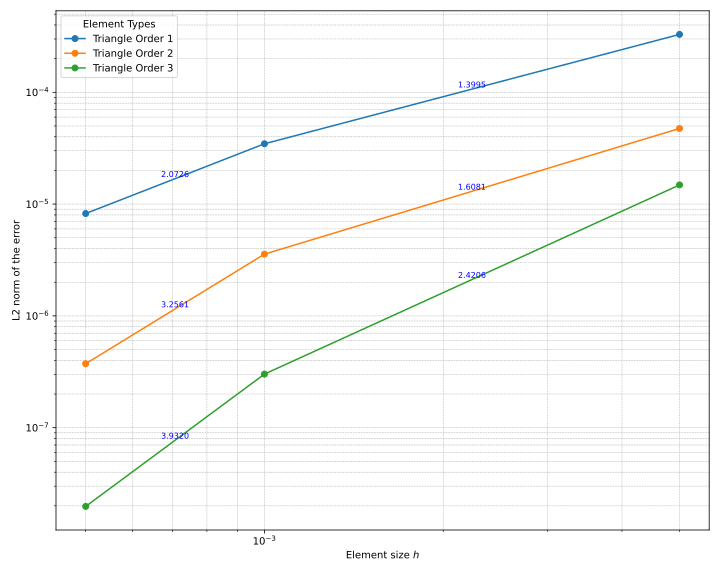

In [4]:
graph_results.plot_convergence(mesh_sizes, errors_l2, type='L2')
display(SVG(filename="pos_processing/pictures/convergence_L2.svg"))

## Figure 2: Convergence of the numerical solution for $L_2$ norm of the error.

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p12_coaxial_electrostatics\pos_processing\pictures\convergence_Energy.svg


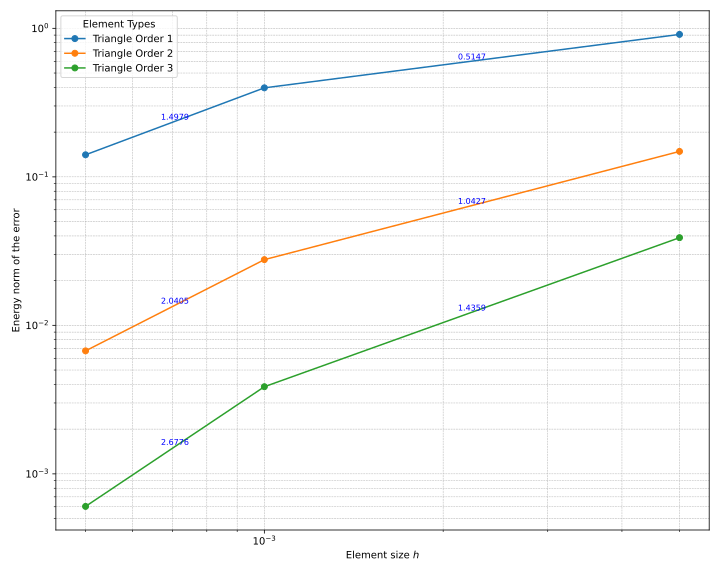

In [5]:
graph_results.plot_convergence(mesh_sizes, errors_energy, type='Energy')
display(SVG(filename="pos_processing/pictures/convergence_Energy.svg"))

## Figure 3: Convergence of the numerical solution for Capacitance

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p12_coaxial_electrostatics\pos_processing\pictures\convergence_capacitance.svg


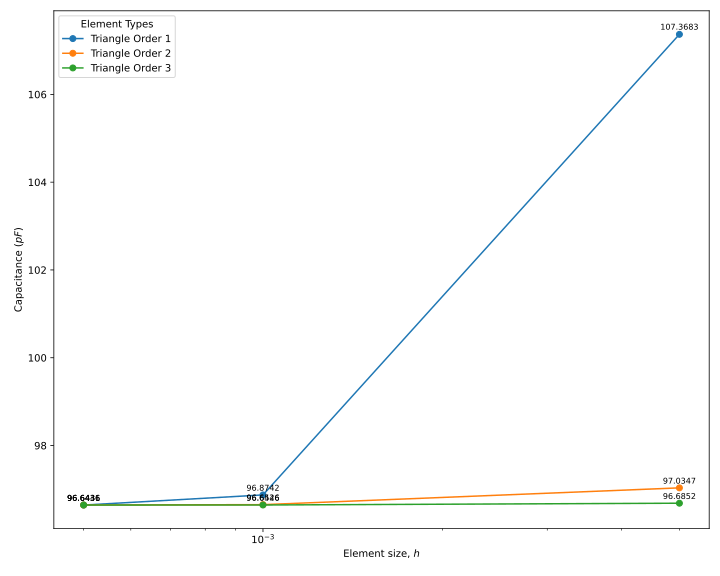

In [6]:
ps.capacitance_convergence(mesh_sizes, capacitances)
display(SVG(filename="pos_processing/pictures/convergence_capacitance.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.